In [1]:
!pip3 install wget
import wget
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2 as cv
import numpy as np
import requests
import json
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# source: https://stackoverflow.com/posts/49208362/revisions
# A helper function converting opencv images to squres
def get_square(image,square_size):

  height,width,x=image.shape
  if(height>width):
    differ=height
  else:
    differ=width
  differ+=4

  mask = np.zeros((differ,differ,x), dtype="uint8")   
  x_pos=int((differ-width)/2)
  y_pos=int((differ-height)/2)
  mask[y_pos:y_pos+height,x_pos:x_pos+width,:]=image[0:height,0:width,:]
  mask=cv.resize(mask,(square_size,square_size),interpolation=cv.INTER_AREA)

  return mask 
  
# A helper function converting opencv images to certain dimensions
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
  # initialize the dimensions of the image to be resized and
  # grab the image size
  dim = None
  (h, w) = image.shape[:2]

  # if both the width and height are None, then return the
  # original image
  if width is None and height is None:
      return image

  # check to see if the width is None
  if width is None:
      # calculate the ratio of the height and construct the
      # dimensions
      r = height / float(h)
      dim = (int(w * r), height)

  # otherwise, the height is None
  else:
      # calculate the ratio of the width and construct the
      # dimensions
      r = width / float(w)
      dim = (width, int(h * r))

  # resize the image
  resized = cv.resize(image, dim, interpolation = inter)

  # return the resized image
  return resized

##Data aquisition

In [0]:
# The database we'll be working with contains images of skin conditions, a segmentation images,
# and metadata about diagnosees, patient information etc.
# ISIC API - we'll get our data through http
api_root = "https://isic-archive.com/api/v1"
api_image = api_root + "/image?limit={0}&sort=name&sortdir=1&detail=true"
api_image_download = api_root + "/image/{0}/download?contentDisposition=inline" #original resolution
api_image_thumbnail = api_root + "/image/{0}/thumbnail?width=256&height=256"
api_segmentation = api_root + "/segmentation?limit=50&sort=created&sortdir=-1&imageId={0}"
api_segmentation_thumbnail = api_root + "/segmentation/{0}/thumbnail?&contentDisposition=inline&width=256"
api_segmentation_mask = api_root + "/segmentation/{0}/mask?contentDisposition=inline"

In [0]:
#empty folders if they are created already
!rm -rf image_thumbnails/*
!rm -rf segmentation_thumbnails/*
!rm -rf segmentation_masks/*

In [0]:
#create folders for downloaded data
!mkdir -p image_thumbnails/benign
!mkdir -p image_thumbnails/malignant
!mkdir -p segmentation_thumbnails
!mkdir -p segmentation_masks

In [0]:
# Download n images
image_count = 300

response = requests.get(api_image.format(image_count))
json_images = json.loads(response.text)

images = []

for json_image in json_images:
  metadata = json_image['meta']['clinical']

  #skip unknowns and intermediates
  if metadata['benign_malignant'] not in ['benign','malignant']:
    continue

  image_thumbnail_filename = wget.download(api_image_thumbnail.format(json_image['_id']), \
                                           out=f"image_thumbnails/{metadata['benign_malignant']}/"+json_image['_id']+".jpg")
  BGR_image_thumbnail = cv.imread(image_thumbnail_filename)
  image_thumbnail = cv.cvtColor(BGR_image_thumbnail, cv.COLOR_BGR2RGB)
  
  response = requests.get(api_segmentation.format(json_image['_id']))
  json_segmentations = json.loads(response.text)
  
  segmentation_thumbnail_filename = wget.download(api_segmentation_thumbnail.format(json_segmentations[0]['_id']))
  !mv $segmentation_thumbnail_filename "segmentation_thumbnails/"$segmentation_thumbnail_filename
  segmentation_thumbnail_filename = "segmentation_thumbnails/" + segmentation_thumbnail_filename
  BGR_segmentation_thumbnail = cv.imread(segmentation_thumbnail_filename)
  segmentation_thumbnail = cv.cvtColor(BGR_segmentation_thumbnail, cv.COLOR_BGR2RGB)
  
  segmentation_mask_filename = wget.download(api_segmentation_mask.format(json_segmentations[0]['_id']))
  !mv $segmentation_mask_filename "segmentation_masks/"$segmentation_mask_filename
  segmentation_mask_filename = "segmentation_masks/" + segmentation_mask_filename
  BGR_segmentation_mask = cv.imread(segmentation_mask_filename)
  segmentation_mask = cv.cvtColor(BGR_segmentation_mask, cv.COLOR_BGR2RGB)
  segmentation_mask = image_resize(segmentation_mask, width = 256)
  
  images.append([image_thumbnail, segmentation_thumbnail, segmentation_mask, metadata])

###Visualizing data

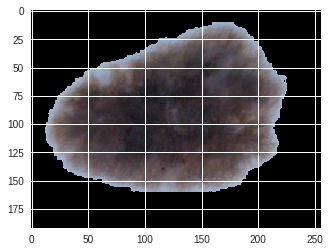

In [7]:
# Applying segmentation mask to thumbnail image
mask = cv.cvtColor(images[0][2], cv.COLOR_RGB2GRAY)
res = cv.bitwise_and(images[0][0],images[0][0],mask = mask)
plt.imshow(res)
plt.show()           

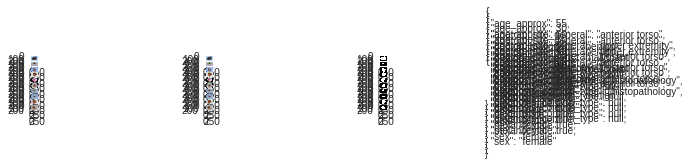

In [8]:
# Showing fragment of the dataset
columns = 4
plt.rcParams["axes.grid"] = False
images_plot = plt.figure(figsize=(12, 3*image_count//30))
for i in range(1, columns*image_count//30+1, columns):
  images_plot.add_subplot(image_count, columns, i)
  plt.imshow(images[i//columns][0])
  images_plot.add_subplot(image_count, columns, i+1)
  plt.imshow(images[i//columns][1])
  images_plot.add_subplot(image_count, columns, i+2)
  plt.imshow(images[i//columns][2])
  ax = images_plot.add_subplot(image_count, columns, i+3)
  ax.axis("off")
  ax.text(0, 0.5, str(json.dumps(images[i//columns][3], indent=2)), fontsize=10, ha='left', va='center')

##Classifying thumbnail images of malignant and benign skin conditions

###Processing metadata (not yet used in the model)

In [0]:
import pandas as pd
import copy

In [10]:
#create DataFrame from metadata list
metadata = copy.deepcopy(np.array(images, copy=True))[:,3]
age_approx=[item.get("age_approx",np.nan) for item in metadata]
anatom_site_general=[item.get("anatom_site_general","unknown") for item in metadata]
melanocytic=[item.get("melanocytic","unknown") for item in metadata]
sex=[item["sex"] for item in metadata]
df_metadata = pd.DataFrame(data=[age_approx,anatom_site_general,melanocytic,sex],index=["age_approx","anatom_site_general","melanocytic","sex"])
df_metadata = df_metadata.T
df_metadata

,age_approx,anatom_site_general,melanocytic,sex
0,55,anterior torso,True,female
1,30,anterior torso,True,female
2,60,upper extremity,True,female
3,30,upper extremity,True,male
4,80,posterior torso,True,male
5,40,anterior torso,True,female
6,25,posterior torso,True,female
7,25,posterior torso,True,female
8,30,anterior torso,True,female
9,30,anterior torso,True,female


In [11]:
#mean age, replace unknown parameters to nan and throw them away
df_metadata['age_approx'].fillna( inplace=True,value=df_metadata['age_approx'].mean())
df_metadata.replace('unknown', np.nan)
df_metadata.dropna(inplace=True)

#one hot encode
df_metadata = pd.get_dummies(df_metadata, columns=["anatom_site_general","melanocytic","sex"])
df_metadata

,age_approx,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_upper extremity,melanocytic_True,sex_female,sex_male
0,55.0,1,0,0,0,0,0,0,1,1,0
1,30.0,1,0,0,0,0,0,0,1,1,0
2,60.0,0,0,0,0,0,0,1,1,1,0
3,30.0,0,0,0,0,0,0,1,1,0,1
4,80.0,0,0,0,0,0,1,0,1,0,1
5,40.0,1,0,0,0,0,0,0,1,1,0
6,25.0,0,0,0,0,0,1,0,1,1,0
7,25.0,0,0,0,0,0,1,0,1,1,0
8,30.0,1,0,0,0,0,0,0,1,1,0
9,30.0,1,0,0,0,0,0,0,1,1,0


In [12]:
#classification of output data
benign_malignant=[item["benign_malignant"] for item in metadata]
df_metadata_out = pd.DataFrame(data=[benign_malignant],index=["benign_malignant"])
df_metadata_out = df_metadata_out.T
df_metadata_out

,benign_malignant
0,benign
1,benign
2,malignant
3,benign
4,malignant
5,benign
6,benign
7,benign
8,benign
9,benign


###Model based on images and diagnosis

In [13]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [14]:
#Creating datagenerators

batch_size = 10
epochs = 100
validation_split=0.3

# rescale thumbnail pictures and read them from directory
train_datagen = ImageDataGenerator(
  rescale=1./255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  validation_split=validation_split)

train_generator = train_datagen.flow_from_directory(
  'image_thumbnails',
  target_size=(64, 64),
  batch_size=batch_size,
  class_mode='binary',
  subset='training')

validation_generator = train_datagen.flow_from_directory(
  'image_thumbnails',
  target_size=(64, 64),
  batch_size=batch_size,
  class_mode='binary',
  subset='validation')

Found 211 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [0]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [16]:
#Building the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 1, activation = 'sigmoid'))

model.compile(optimizer ='adam', loss= 'binary_crossentropy')

early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 3..., activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  


In [17]:
model.fit_generator(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  epochs=epochs,
  verbose=2,
  callbacks=[early_stopping],
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size)

Epoch 1/100
 - 3s - loss: 1.1582 - val_loss: 0.5783
Epoch 2/100
 - 1s - loss: 0.5646 - val_loss: 0.5696
Epoch 3/100
 - 1s - loss: 0.5786 - val_loss: 0.6151
Epoch 4/100
 - 1s - loss: 0.5331 - val_loss: 0.5717
Epoch 5/100
 - 1s - loss: 0.5636 - val_loss: 0.5543
Epoch 6/100
 - 1s - loss: 0.5291 - val_loss: 0.5378
Epoch 7/100
 - 1s - loss: 0.6842 - val_loss: 0.5490
Epoch 8/100
 - 1s - loss: 0.5214 - val_loss: 0.5553
Epoch 9/100
 - 1s - loss: 0.5517 - val_loss: 0.6110
Epoch 10/100
 - 1s - loss: 0.4516 - val_loss: 0.5759
Epoch 11/100
 - 1s - loss: 0.5460 - val_loss: 0.5381
Epoch 12/100
 - 1s - loss: 0.4750 - val_loss: 0.6184
Epoch 13/100
 - 1s - loss: 0.5947 - val_loss: 0.5201
Epoch 14/100
 - 1s - loss: 0.5186 - val_loss: 0.5475
Epoch 15/100
 - 1s - loss: 0.5422 - val_loss: 0.5729
Epoch 16/100
 - 1s - loss: 0.4825 - val_loss: 0.5574
Epoch 17/100
 - 1s - loss: 0.5074 - val_loss: 0.5310
Epoch 18/100
 - 1s - loss: 0.4884 - val_loss: 0.6052
Epoch 19/100
 - 1s - loss: 0.5164 - val_loss: 0.5822
Ep